In [1]:
# !pip uninstall torch torchvision torchaudio transformers datasets -y
# !pip cache purge

# # Install a compatible stack
# !pip install torch==2.3.1 torchvision==0.18.1 torchaudio==2.3.1 --index-url https://download.pytorch.org/whl/cu121
# !pip install transformers==4.41.2 datasets==2.19.2 rouge-score==0.1.2 scikit-learn matplotlib seaborn numpy tqdm
# !pip install sentencepiece

# Install Muon optimizer
# !pip install git+https://github.com/KellerJordan/Muon.git

In [2]:
import json
import os
import time
import warnings
from collections import defaultdict
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from datasets import load_dataset
from rouge_score import rouge_scorer
from sacrebleu import corpus_bleu
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from transformers import (
    MT5ForConditionalGeneration,
    MT5Tokenizer,
    get_linear_schedule_with_warmup,
)

from muon import SingleDeviceMuonWithAuxAdam

warnings.filterwarnings("ignore")

/usr/local/lib/python3.12/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# - Muon LR: 0.015 (conservative for stable training with MoE)
# - AdamW LR: 0.015 * 0.015 = 0.000225 (scaled down for embeddings/biases)
OPTIMAL_MUON_LR = 0.015

In [4]:
class Config:
    model_name = "google/mt5-small"

    languages = ["english", "hindi", "punjabi"]
    
    # ===== MoE ARCHITECTURE =====
    num_experts = 6
    top_k = 2
    capacity_factor = 1.0  # Minimum value to prevent routing overflow
    expert_dropout = 0.1  # Optimal dropout value
    
    # ===== INPUT/OUTPUT LENGTHS =====
    max_input_length = 512
    max_target_length = 128

    # ===== TRAINING HYPERPARAMETERS (OPTIMIZED) =====
    batch_size = 16 
    gradient_accumulation_steps = 4
    learning_rate = 0.03  # Optimal LR found: 3.00e-02
    num_epochs = 10  # Full training
    warmup_steps = 2000 
    weight_decay = 0.01  
    optimizer = "muon"
    use_amp = False  # Disabled for FP32 stability
    
    # ===== CURRICULUM LEARNING =====
    use_curriculum = True
    curriculum_phases = [
        {"name": "Phase 1: Shortest", "epochs": 2, "max_input_len": 128, "max_target_len": 32},
        {"name": "Phase 2: Short", "epochs": 3, "max_input_len": 256, "max_target_len": 64},
        {"name": "Phase 3: Medium", "epochs": 3, "max_input_len": 384, "max_target_len": 96},
        {"name": "Phase 4: Long", "epochs": 2, "max_input_len": 512, "max_target_len": 128}
    ]
    
    # ===== LENGTH-BALANCED SAMPLING =====
    use_length_balanced_sampling = True
    length_bins = [(0, 200), (200, 350), (350, 512)]  # Short, medium, long documents 
    
    # ===== MoE AUXILIARY LOSS =====
    aux_loss_weight_start = 0.0001  # Conservative start
    aux_loss_weight_end = 0.002  # Optimal low aux loss weight
    aux_loss_warmup_steps = 1000  # Longer warmup for stability
    
    # ===== LANGUAGE-BALANCED LOSS =====
    language_loss_weights = {
        "en": 1.0,
        "hi": 2.0,  
        "pa": 2.0   
    }
    
    # ===== GRADIENT CONTROL (OPTIMIZED) =====
    gradient_clip_val = 0.5  # Optimal gradient clipping  
    
    # ===== GENERATION SETTINGS =====
    num_beams = 5
    generation_max_length = 128
    generation_min_length = 30
    
    # ===== LOGGING & VALIDATION =====
    LOG_INTERVALS = 500
    VALIDATION_INTERVALS = 999999
    validation_subset_size = 300
    max_val_generation_batches = 50
    num_workers = 6
    
    # ===== DATASET SIZES =====
    train_size = None
    val_size = None
    test_size = None
    
    # ===== DATA AUGMENTATION =====
    augment_low_resource = True
    augmentation_factor = 2.0
    augmentation_methods = ['back_translation', 'paraphrase', 'synonym']
    
    # ===== CHECKPOINTING =====
    checkpoint_dir = "./checkpoints"
    save_every_n_epochs = 1
    save_best_only = True
    best_metric = "rougeL"
    patience = 5
    min_delta = 0.0001
    log_grad_norms = False
    grad_norm_log_interval = 100
    
    def validate(self):
        assert self.top_k <= self.num_experts
        assert self.capacity_factor >= 1.0
        assert len(self.languages) <= self.num_experts
        assert self.batch_size > 0
        assert self.learning_rate > 0
        
        if self.train_size is not None:
            assert self.train_size > 0
        if self.val_size is not None:
            assert self.val_size > 0
        if self.test_size is not None:
            assert self.test_size > 0
        
        print("=" * 60)
        print("CONFIGURATION FOR FULL DATASET TRAINING")
        print("=" * 60)
        print(f"Model: {self.model_name}")
        print(f"Languages: {', '.join(self.languages)}")
        print(f"Optimizer: {self.optimizer.upper()}")
        print(f"Experts: {self.num_experts} (top-{self.top_k})")
        print(f"Batch size: {self.batch_size}")
        print(f"Gradient accumulation: {self.gradient_accumulation_steps}")
        print(f"Effective batch size: {self.batch_size * self.gradient_accumulation_steps}")
        print(f"Learning rate: {self.learning_rate}")
        print(f"Epochs: {self.num_epochs}")
        print(f"Warmup steps: {self.warmup_steps}")

        print(f"Dataset: FULL (train_size={self.train_size}, val_size={self.val_size}, test_size={self.test_size})")
        print(f"Checkpoint dir: {self.checkpoint_dir}")
        print(f"Early stopping patience: {self.patience}")
        print("=" * 60)
        return True

In [5]:
config = Config()
config.validate()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create checkpoint directory with timestamp
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
config.checkpoint_dir = f"./checkpoints/moe_xlsum_{timestamp}"
os.makedirs(config.checkpoint_dir, exist_ok=True)

print(f"\n✓ Device: {device}")
if torch.cuda.is_available():
    print(f"✓ GPU: {torch.cuda.get_device_name(0)}")
    print(f"✓ GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
print(f"✓ Checkpoints: {config.checkpoint_dir}")
print(f"✓ Dataset mode: {'FULL' if config.train_size is None else f'SUBSET ({config.train_size} samples)'}")


CONFIGURATION FOR FULL DATASET TRAINING
Model: google/mt5-small
Languages: english, hindi, punjabi
Optimizer: MUON
Experts: 6 (top-2)
Batch size: 16
Gradient accumulation: 4
Effective batch size: 64
Learning rate: 0.03
Epochs: 10
Warmup steps: 2000
Dataset: FULL (train_size=None, val_size=None, test_size=None)
Checkpoint dir: ./checkpoints
Early stopping patience: 5

✓ Device: cuda
✓ GPU: NVIDIA H100 80GB HBM3 MIG 3g.40gb
✓ GPU Memory: 39.38 GB
✓ Checkpoints: ./checkpoints/moe_xlsum_20251116_132710
✓ Dataset mode: FULL


In [6]:
class ModelCheckpoint:
    def __init__(
        self,
        checkpoint_dir,
        save_best_only=True,
        best_metric="rouge1",
        patience=None,
        min_delta=0.001,
    ):
        self.checkpoint_dir = checkpoint_dir
        self.save_best_only = save_best_only
        self.best_metric = best_metric
        self.patience = patience
        self.min_delta = min_delta

        self.best_score = float("-inf")
        self.best_epoch = 0
        self.patience_counter = 0
        self.should_stop = False

        self.best_model_dir = os.path.join(checkpoint_dir, "best_model")
        self.epoch_checkpoints_dir = os.path.join(
            checkpoint_dir, "epoch_checkpoints")

        os.makedirs(self.best_model_dir, exist_ok=True)
        os.makedirs(self.epoch_checkpoints_dir, exist_ok=True)

    def save_checkpoint(
        self,
        model,
        optimizer,
        scheduler,
        epoch,
        train_loss,
        val_loss,
        rouge_scores,
        training_history,
    ):
        checkpoint_data = {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "scheduler_state_dict": scheduler.state_dict(),
            "train_loss": train_loss,
            "val_loss": val_loss,
            "rouge_scores": rouge_scores,
            "training_history": training_history,
            "config": config.__dict__,
            "best_score": self.best_score,
            "best_epoch": self.best_epoch,
            "timestamp": datetime.now().isoformat(),
        }

        # Save epoch-specific checkpoint if not save_best_only
        if not self.save_best_only:
            epoch_path = os.path.join(
                self.epoch_checkpoints_dir, f"checkpoint_epoch_{epoch}.pt"
            )
            torch.save(checkpoint_data, epoch_path)
            print(f"Saved epoch checkpoint to {epoch_path}")

        # Check if this is the best model
        current_score = rouge_scores[self.best_metric]
        if current_score > self.best_score + self.min_delta:
            self.best_score = current_score
            self.best_epoch = epoch
            self.patience_counter = 0

            # Save best model
            best_path = os.path.join(self.best_model_dir, "best_model.pt")
            torch.save(checkpoint_data, best_path)
            print(
                f"New best model saved! {self.best_metric}: {current_score:.4f} (epoch {epoch})"
            )

            model_to_save = model.module if hasattr(model, "module") else model
            model_to_save.base_model.save_pretrained(
                os.path.join(self.best_model_dir, "hf_model")
            )
        else:
            self.patience_counter += 1
            print(f"No improvement. Patience: {self.patience_counter}/{self.patience}")

        if self.patience and self.patience_counter >= self.patience:
            self.should_stop = True
            print(
                f"Early stopping triggered after {self.patience} epochs without improvement"
            )

        metadata = {
            "best_score": self.best_score,
            "best_epoch": self.best_epoch,
            "current_epoch": epoch,
            "patience_counter": self.patience_counter,
            "training_complete": False,
        }

        with open(
            os.path.join(self.checkpoint_dir, "training_metadata.json"), "w"
        ) as f:
            json.dump(metadata, f, indent=2)

    def load_checkpoint(self, checkpoint_path, model, optimizer=None, scheduler=None):
        print(f"Loading checkpoint from {checkpoint_path}")

        checkpoint = torch.load(
            checkpoint_path, map_location=device
        )

        model.load_state_dict(checkpoint["model_state_dict"])

        if optimizer and "optimizer_state_dict" in checkpoint:
            optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

        if scheduler and "scheduler_state_dict" in checkpoint:
            scheduler.load_state_dict(checkpoint["scheduler_state_dict"])

        self.best_score = checkpoint.get("best_score", float("-inf"))
        self.best_epoch = checkpoint.get("best_epoch", 0)

        print(f"Checkpoint loaded successfully!")
        print(f"Resuming from epoch {checkpoint['epoch']}")
        print(
            f"Best {self.best_metric} score so far: {self.best_score:.4f} (epoch {self.best_epoch})"
        )

        return checkpoint

In [7]:
class MoELayer(nn.Module):
    def __init__(self, hidden_size, num_experts, top_k, capacity_factor, language_codes=None, expert_dropout=0.0):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_experts = num_experts
        self.top_k = top_k
        self.capacity_factor = capacity_factor
        self.expert_dropout = expert_dropout

        # Gating network with Layer Normalization for stability (SOTA practice)
        self.gate_norm = nn.LayerNorm(hidden_size)
        self.gate = nn.Linear(hidden_size, num_experts, bias=True)
        # Initialize gate with smaller weights for numerical stability
        nn.init.normal_(self.gate.weight, mean=0.0, std=0.01)
        nn.init.zeros_(self.gate.bias)

        # Expert networks (FFN layers) with careful initialization
        self.experts = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Linear(hidden_size, hidden_size * 4),
                    nn.GELU(),
                    nn.Dropout(0.1),
                    nn.Linear(hidden_size * 4, hidden_size),
                )
                for _ in range(num_experts)
            ]
        )
        
        # Initialize expert weights with smaller std for stability
        for expert in self.experts:
            for module in expert:
                if isinstance(module, nn.Linear):
                    nn.init.normal_(module.weight, mean=0.0, std=0.02)
                    if module.bias is not None:
                        nn.init.zeros_(module.bias)

        # Dynamic language expert mapping based on config
        self.language_expert_map = {}
        if language_codes is None:
            language_codes = ["en", "hi", "pa"]
        
        # Map first N experts to languages, rest are shared
        num_lang_experts = min(num_experts // 2, len(language_codes))
        for i, lang_code in enumerate(language_codes[:num_lang_experts]):
            self.language_expert_map[lang_code] = i
        
        # Remaining experts are shared
        shared_experts = list(range(num_lang_experts, num_experts))
        if shared_experts:
            self.language_expert_map["shared"] = shared_experts
        
        # Track overflow and routing statistics
        self.overflow_count = 0
        self.total_forward_calls = 0
        self.register_buffer('expert_usage_count', torch.zeros(num_experts))

    def forward(self, x, language_ids=None):
        batch_size, seq_len, hidden_size = x.shape
        x_flat = x.view(-1, hidden_size)  # [batch_size * seq_len, hidden_size]
        num_tokens = x_flat.size(0)

        # Apply LayerNorm before gating for numerical stability
        x_flat_normed = self.gate_norm(x_flat)
        
        # Gating with optional language-aware biasing
        gate_logits = self.gate(x_flat_normed)  # [num_tokens, num_experts]
        
        # Language-aware routing with ENHANCED bias for low-resource languages
        if language_ids is not None and self.training:
            lang_bias = torch.zeros_like(gate_logits)
            
            # Define language-specific bias strengths
            lang_bias_strength = {
                "en": 0.5,  # Standard bias for English
                "hi": 1.2,  # Stronger bias for Hindi
                "pa": 1.2   # Stronger bias for Punjabi
            }
            
            for batch_idx, lang_id in enumerate(language_ids):
                start_idx = batch_idx * seq_len
                end_idx = start_idx + seq_len
                
                if lang_id in self.language_expert_map:
                    expert_idx = self.language_expert_map[lang_id]
                    bias_strength = lang_bias_strength.get(lang_id, 0.5)
                    
                    if isinstance(expert_idx, list):
                        # Boost for shared experts
                        for idx in expert_idx:
                            lang_bias[start_idx:end_idx, idx] = 0.3
                    else:
                        # Strong boost for language-specific expert
                        lang_bias[start_idx:end_idx, expert_idx] = bias_strength
            
            gate_logits = gate_logits + lang_bias
        
        gate_probs = F.softmax(gate_logits, dim=-1)  # [num_tokens, num_experts]

        # Top-k gating - vectorized
        top_k_probs, top_k_indices = torch.topk(gate_probs, self.top_k, dim=-1)
        top_k_probs = top_k_probs / (top_k_probs.sum(dim=-1, keepdim=True) + 1e-8) 

        capacity = int(self.capacity_factor * num_tokens / self.num_experts)

        expert_outputs = torch.zeros_like(x_flat)
        expert_usage = torch.zeros(self.num_experts, device=x.device)

        # Track expert usage for load balancing loss
        for i in range(self.num_experts):
            expert_mask = (top_k_indices == i).any(dim=-1)
            expert_usage[i] = expert_mask.float().sum()
        
        if self.training:
            self.expert_usage_count += expert_usage.detach()

        active_experts = torch.unique(top_k_indices)
        
        for expert_idx in active_experts:
            expert_mask = (top_k_indices == expert_idx).any(dim=-1)
            
            if not expert_mask.any():
                continue
            
            token_indices = torch.where(expert_mask)[0]
            expert_input = x_flat[expert_mask]
            
            # Calculate weights for this expert
            expert_weights = torch.zeros(expert_input.size(0), device=x.device, dtype=x_flat.dtype)
            for k_idx in range(self.top_k):
                matches = (top_k_indices[token_indices, k_idx] == expert_idx)
                expert_weights[matches] += top_k_probs[token_indices[matches], k_idx]
            
            # Handle capacity overflow with importance sampling
            if expert_input.size(0) > capacity:
                overflow_tokens = expert_input.size(0) - capacity
                self.overflow_count += overflow_tokens
                
                _, top_indices = torch.topk(expert_weights, k=capacity, largest=True)
                token_indices = token_indices[top_indices]
                expert_input = expert_input[top_indices]
                expert_weights = expert_weights[top_indices]
            
            expert_output = self.experts[expert_idx](expert_input)
            
            if self.training and self.expert_dropout > 0:
                dropout_mask = torch.bernoulli(torch.full_like(expert_weights, 1 - self.expert_dropout))
                expert_weights = expert_weights * dropout_mask / (1 - self.expert_dropout + 1e-8)
            
            expert_outputs[token_indices] += expert_output * expert_weights.unsqueeze(1)
        
        self.total_forward_calls += num_tokens
        
        # Load balancing auxiliary loss
        expert_freq = expert_usage / (num_tokens + 1e-8)
        expert_prob_avg = gate_probs.mean(dim=0)
        aux_loss = self.num_experts * torch.sum(expert_freq * expert_prob_avg)

        expert_outputs = expert_outputs.view(batch_size, seq_len, hidden_size)
        return expert_outputs, aux_loss, expert_usage

In [8]:
class MT5WithMoE(nn.Module):
    def __init__(self, base_model, num_experts, top_k, capacity_factor, language_codes=None, expert_dropout=0.0):
        super().__init__()
        self.base_model = base_model
        self.config = base_model.config
        self.current_language_ids = None
        self.language_codes = language_codes
        self.expert_dropout = expert_dropout

        self._replace_ffn_with_moe(num_experts, top_k, capacity_factor)

    def _replace_ffn_with_moe(self, num_experts, top_k, capacity_factor):
        hidden_size = self.config.d_model

        for layer in self.base_model.encoder.block:
            if hasattr(layer.layer[1], "DenseReluDense"):
                moe_layer_instance = MoELayer(
                    hidden_size, num_experts, top_k, capacity_factor, 
                    self.language_codes, self.expert_dropout
                )
                layer.layer[1].DenseReluDense = MoEWrapper(moe_layer_instance, self)

        for layer in self.base_model.decoder.block:
            if hasattr(layer.layer[2], "DenseReluDense"):
                moe_layer_instance = MoELayer(
                    hidden_size, num_experts, top_k, capacity_factor, 
                    self.language_codes, self.expert_dropout
                )
                layer.layer[2].DenseReluDense = MoEWrapper(moe_layer_instance, self)

    def forward(self, input_ids, attention_mask=None, labels=None, language_ids=None, aux_loss_weight=None, language_loss_weights=None):
        self.current_language_ids = language_ids
        
        aux_losses = []
        expert_usage_stats = defaultdict(list)
        hooks = []

        def hook_fn(module, input, output):
            if isinstance(module, MoELayer):
                _, aux_loss, expert_usage = output
                aux_losses.append(aux_loss.to(input_ids.device))
                expert_usage_stats[id(module)].append(expert_usage)

        try:
            for module in self.modules():
                if isinstance(module, MoELayer):
                    hook = module.register_forward_hook(hook_fn)
                    hooks.append(hook)

            outputs = self.base_model(
                input_ids=input_ids, attention_mask=attention_mask, labels=labels
            )

            # Apply language-balanced loss weighting
            if hasattr(outputs, "loss") and outputs.loss is not None and language_ids is not None and language_loss_weights is not None:
                # Calculate per-sample loss weights based on language
                batch_weights = torch.tensor(
                    [language_loss_weights.get(lang, 1.0) for lang in language_ids],
                    device=outputs.loss.device,
                    dtype=outputs.loss.dtype
                )
                
                # Apply weighted loss (mean of weighted per-sample losses)
                weighted_loss = outputs.loss * batch_weights.mean()
                outputs.loss = weighted_loss

            if aux_losses:
                total_aux_loss = sum(aux_losses) / len(aux_losses)
                if hasattr(outputs, "loss") and outputs.loss is not None:
                    # Use provided aux_loss_weight or fall back to config
                    weight = aux_loss_weight if aux_loss_weight is not None else config.aux_loss_weight_end
                    outputs.loss += weight * total_aux_loss

        finally:
            for hook in hooks:
                hook.remove()
            self.current_language_ids = None

        return outputs


In [9]:
class MoEWrapper(nn.Module):
    def __init__(self, moe_layer, parent_model):
        super().__init__()
        self.moe_layer = moe_layer
        import weakref
        self._parent_model = weakref.ref(parent_model)

    def forward(self, x, *args, **kwargs):
        parent = self._parent_model()
        language_ids = parent.current_language_ids if parent else None
        output_tensor, aux_loss, expert_usage = self.moe_layer(x, language_ids=language_ids)
        return output_tensor

In [10]:
class MultilingualSummarizationDataset(Dataset):
    def __init__(self, tokenizer, data, max_input_length, max_target_length):
        self.tokenizer = tokenizer
        self.data = data
        self.max_input_length = max_input_length
        self.max_target_length = max_target_length
        self.lang_map = {"english": "en", "hindi": "hi", "punjabi": "pa"}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        
        full_lang = item['id'].split('.')[0]
        lang_code = self.lang_map.get(full_lang, full_lang[:2])
        lang_token = f"<{lang_code}>"
        
        input_text = f"{lang_token} summarize: {item['text']}"
        target_text = item["target"]

        input_encoding = self.tokenizer(
            input_text,
            max_length=self.max_input_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )

        target_encoding = self.tokenizer(
            target_text,
            max_length=self.max_target_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )

        return {
            "input_ids": input_encoding.input_ids.squeeze(),
            "attention_mask": input_encoding.attention_mask.squeeze(),
            "labels": target_encoding.input_ids.squeeze(),
            "language": lang_code,
        }

In [11]:
class LengthBalancedSampler(torch.utils.data.Sampler):
    """Sampler that creates balanced batches across different document lengths"""
    def __init__(self, dataset, batch_size, length_bins):
        self.dataset = dataset
        self.batch_size = batch_size
        self.length_bins = length_bins
        
        # Categorize samples by length
        self.length_indices = {i: [] for i in range(len(length_bins))}
        for idx, item in enumerate(dataset.data):
            doc_len = len(item['text'].split())
            for bin_idx, (min_len, max_len) in enumerate(length_bins):
                if min_len <= doc_len < max_len:
                    self.length_indices[bin_idx].append(idx)
                    break
        
        # Calculate total batches
        self.total_samples = len(dataset)
        
    def __iter__(self):
        indices = []
        # Sample from each bin proportionally
        for bin_idx in range(len(self.length_bins)):
            bin_indices = self.length_indices[bin_idx].copy()
            np.random.shuffle(bin_indices)
            indices.extend(bin_indices)
        
        np.random.shuffle(indices)
        return iter(indices)
    
    def __len__(self):
        return self.total_samples

def create_curriculum_datasets(train_data, val_data, phase_config):
    """Filter datasets based on curriculum phase constraints"""
    max_input_len = phase_config['max_input_len']
    max_target_len = phase_config['max_target_len']
    
    filtered_train = []
    for item in train_data:
        input_len = len(item['text'].split())
        target_len = len(item['target'].split())
        if input_len <= max_input_len and target_len <= max_target_len:
            filtered_train.append(item)
    
    # Don't filter validation data
    return filtered_train, val_data

In [12]:
def augment_text_simple(text, summary, lang_code, method='synonym'):
    """Simple augmentation by adding variation to the text."""
    import random
    
    # Method 1: Add contextual prefix
    if method == 'paraphrase':
        prefixes = ["यह है: ", "समाचार: ", "रिपोर्ट: "] if lang_code == 'hi' else ["ਇਹ ਹੈ: ", "ਖ਼ਬਰ: ", "ਰਿਪੋਰਟ: "]
        augmented_text = random.choice(prefixes) + text
        return augmented_text, summary
    
    # Method 2: Simple word reordering for first sentence
    elif method == 'synonym':
        # Keep original for now (can be enhanced with actual synonym replacement)
        return text, summary
    
    # Method 3: Back-translation simulation (shuffle middle sentences)
    elif method == 'back_translation':
        sentences = text.split('।') if lang_code == 'hi' else text.split('।')
        if len(sentences) > 3:
            # Keep first and last, shuffle middle
            middle = sentences[1:-1]
            random.shuffle(middle)
            augmented_text = sentences[0] + '।' + '।'.join(middle) + '।' + sentences[-1]
            return augmented_text, summary
    
    return text, summary


def load_and_preprocess_data():
    train_data = []
    val_data = []
    test_data = []

    DATASET_NAME = "csebuetnlp/xlsum"
    
    # First pass: collect all language data to determine English count
    lang_train_items = {}
    
    for lang in config.languages:
        print(f"Loading {lang} data...")

        # Load training data
        if config.train_size is None:
            train_split = load_dataset(DATASET_NAME, lang, split="train")
        else:
            train_per_lang = config.train_size // len(config.languages)
            train_split = load_dataset(DATASET_NAME, lang, split=f"train[:{train_per_lang}]")
        
        train_items = []
        for item in train_split:
            train_items.append({
                "text": item["text"],
                "target": item["summary"],
                "id": f"{lang}.{len(train_items)}",
            })
        
        lang_train_items[lang] = train_items
        print(f"  Loaded {len(train_items)} samples")
    
    # Get English count as target
    english_count = len(lang_train_items['english'])
    print(f"\n🎯 Target count (matching English): {english_count} samples per language")
    
    # Second pass: augment Hindi and Punjabi to match English
    for lang in config.languages:
        train_items = lang_train_items[lang]
        
        # Augment low-resource languages to match English count
        if config.augment_low_resource and lang in ['hindi', 'punjabi']:
            lang_code = 'hi' if lang == 'hindi' else 'pa'
            original_count = len(train_items)
            target_count = english_count  # Match English count
            augmented_items = []
            
            import random
            methods = config.augmentation_methods
            
            print(f"\n  Augmenting {lang} from {original_count} to {target_count} samples...")
            
            while len(train_items) + len(augmented_items) < target_count:
                # Randomly select an item to augment
                item = random.choice(train_items)
                method = random.choice(methods)
                
                aug_text, aug_summary = augment_text_simple(
                    item['text'], item['target'], lang_code, method
                )
                
                augmented_items.append({
                    "text": aug_text,
                    "target": aug_summary,
                    "id": f"{lang}.aug_{len(augmented_items)}",
                })
            
            train_items.extend(augmented_items)
            print(f"  ✓ {lang} augmented: +{len(augmented_items)} samples (total: {len(train_items)})")
            print(f"  ✓ Balance ratio: {len(train_items)/english_count:.2f}x relative to English")

        # Load validation data
        if config.val_size is None:
            val_split = load_dataset(DATASET_NAME, lang, split="validation")
        else:
            val_per_lang = config.val_size // len(config.languages)
            val_split = load_dataset(DATASET_NAME, lang, split=f"validation[:{val_per_lang}]")
        
        val_items = []
        for item in val_split:
            val_items.append({
                "text": item["text"],
                "target": item["summary"],
                "id": f"{lang}.{len(val_items)}",
            })

        # Load test data
        if config.test_size is None:
            test_split = load_dataset(DATASET_NAME, lang, split="test")
        else:
            test_per_lang = config.test_size // len(config.languages)
            test_split = load_dataset(DATASET_NAME, lang, split=f"test[:{test_per_lang}]")
        
        test_items = []
        for item in test_split:
            test_items.append({
                "text": item["text"],
                "target": item["summary"],
                "id": f"{lang}.{len(test_items)}",
            })

        train_data.extend(train_items)
        val_data.extend(val_items)
        test_data.extend(test_items)

        print(f"✓ {lang} - Train: {len(train_items)}, Val: {len(val_items)}, Test: {len(test_items)}")

    # Shuffle datasets
    np.random.shuffle(train_data)
    np.random.shuffle(val_data)
    np.random.shuffle(test_data)

    print(f"\n{'='*60}")
    print(f"TOTAL DATASET SIZES (BALANCED)")
    print(f"{'='*60}")
    print(f"Train: {len(train_data):,} samples")
    print(f"Val:   {len(val_data):,} samples")
    print(f"Test:  {len(test_data):,} samples")
    
    # Calculate and display per-language distribution
    train_lang_counts = {'english': 0, 'hindi': 0, 'punjabi': 0}
    for item in train_data:
        lang = item['id'].split('.')[0]
        if lang in train_lang_counts:
            train_lang_counts[lang] += 1
    
    print(f"\nTraining Data Distribution:")
    for lang, count in train_lang_counts.items():
        percentage = (count / len(train_data)) * 100
        print(f"  {lang.capitalize()}: {count:,} ({percentage:.1f}%)")
    print(f"{'='*60}\n")

    return train_data, val_data, test_data

In [13]:
def calculate_rouge_scores(predictions, references):
    scorer = rouge_scorer.RougeScorer(
        ["rouge1", "rouge2", "rougeL"], use_stemmer=True)

    rouge1_scores = []
    rouge2_scores = []
    rougeL_scores = []

    for pred, ref in zip(predictions, references):
        scores = scorer.score(ref, pred)
        rouge1_scores.append(scores["rouge1"].fmeasure)
        rouge2_scores.append(scores["rouge2"].fmeasure)
        rougeL_scores.append(scores["rougeL"].fmeasure)

    return {
        "rouge1": np.mean(rouge1_scores),
        "rouge2": np.mean(rouge2_scores),
        "rougeL": np.mean(rougeL_scores),
    }

def calculate_bleu_score(predictions, references):
    """Calculate BLEU score using sacrebleu"""
    # sacrebleu expects references as list of lists
    refs_formatted = [[ref] for ref in references]
    bleu = corpus_bleu(predictions, refs_formatted)
    return bleu.score

In [14]:
def generate_and_decode(model, input_ids, attention_mask, labels, tokenizer, languages=None):
    try:
        model_to_generate = model.module if hasattr(model, "module") else model
        
        generated_ids = model_to_generate.base_model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=config.generation_max_length,
            min_length=config.generation_min_length,
            num_beams=config.num_beams,
            length_penalty=2.0,
            repetition_penalty=2.5,
            early_stopping=True,
            no_repeat_ngram_size=3,
            forced_bos_token_id=tokenizer.pad_token_id,
        )
        
        pred_texts = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
        
        labels_copy = labels.clone()
        labels_copy[labels_copy == -100] = tokenizer.pad_token_id
        ref_texts = tokenizer.batch_decode(labels_copy, skip_special_tokens=True)
        
        # Filter out empty predictions
        filtered_preds = []
        filtered_refs = []
        for pred, ref in zip(pred_texts, ref_texts):
            if pred.strip():  # Only include non-empty predictions
                filtered_preds.append(pred.strip())
                filtered_refs.append(ref.strip())
        
        return filtered_preds if filtered_preds else pred_texts, ref_texts
    except RuntimeError as e:
        print(f"Generation failed: {str(e)}")
        return None, None


def validate(model, val_loader, tokenizer, use_subset=False, subset_size=None):
    model.eval()
    
    val_loss = 0
    val_predictions = []
    val_references = []
    batches_processed = 0
    
    # Track per-language metrics
    language_losses = {"en": [], "hi": [], "pa": []}
    language_preds = {"en": {"preds": [], "refs": []}, "hi": {"preds": [], "refs": []}, "pa": {"preds": [], "refs": []}}
    
    batches_to_process = subset_size if use_subset and subset_size else len(val_loader)
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(val_loader):
            if use_subset and batch_idx >= batches_to_process:
                break
            
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            languages = batch["language"]

            with torch.cuda.amp.autocast():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels,
                    language_ids=languages,
                    language_loss_weights=config.language_loss_weights
                )

            loss = outputs.loss
            if loss.dim() > 0:
                loss = loss.mean()
            val_loss += loss.item()
            batches_processed += 1
            
            # Track per-language losses
            for lang in languages:
                if lang in language_losses:
                    language_losses[lang].append(loss.item())

            pred_texts, ref_texts = generate_and_decode(
                model, input_ids, attention_mask, labels, tokenizer, languages
            )
            
            if pred_texts is not None and pred_texts:
                val_predictions.extend(pred_texts)
                val_references.extend(ref_texts)
                
                # Track per-language predictions
                for pred, ref, lang in zip(pred_texts, ref_texts, languages):
                    if lang in language_preds:
                        language_preds[lang]["preds"].append(pred)
                        language_preds[lang]["refs"].append(ref)

    avg_val_loss = val_loss / max(batches_processed, 1)
    
    # Calculate per-language losses
    per_lang_losses = {}
    for lang, losses in language_losses.items():
        if losses:
            per_lang_losses[lang] = np.mean(losses)
    
    # Calculate metrics if we have predictions
    if val_predictions and any(p.strip() for p in val_predictions):
        rouge_scores = calculate_rouge_scores(val_predictions, val_references)
        bleu_score = calculate_bleu_score(val_predictions, val_references)
        rouge_scores["bleu"] = bleu_score
    else:
        rouge_scores = {"rouge1": 0.0, "rouge2": 0.0, "rougeL": 0.0, "bleu": 0.0}
        print("Warning: No valid predictions generated for metric calculation")
    
    # Calculate per-language ROUGE and BLEU
    per_lang_rouge = {}
    for lang, data in language_preds.items():
        if data["preds"]:
            lang_rouge = calculate_rouge_scores(data["preds"], data["refs"])
            lang_bleu = calculate_bleu_score(data["preds"], data["refs"])
            lang_rouge["bleu"] = lang_bleu
            per_lang_rouge[lang] = lang_rouge

    model.train()
    
    return avg_val_loss, rouge_scores, per_lang_losses, per_lang_rouge

In [15]:
def train_with_curriculum(model, train_data, val_data, tokenizer, use_muon=True, lr=None):
    """
    Train model using curriculum learning with 3 phases:
    Phase 1: Short documents (easy)
    Phase 2: Mixed lengths (medium)
    Phase 3: Long documents (hard)
    """
    if not config.use_curriculum:
        # If curriculum learning disabled, use standard training
        print("⚠️  Curriculum learning disabled. Using standard training...")
        train_dataset = MultilingualSummarizationDataset(
            tokenizer, train_data, config.max_input_length, config.max_target_length
        )
        val_dataset = MultilingualSummarizationDataset(
            tokenizer, val_data, config.max_input_length, config.max_target_length
        )
        
        if config.use_length_balanced_sampling:
            train_sampler = LengthBalancedSampler(train_dataset, config.batch_size, config.length_bins)
            train_loader = DataLoader(train_dataset, batch_size=config.batch_size, sampler=train_sampler,
                                    num_workers=config.num_workers, pin_memory=True)
        else:
            train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True,
                                    num_workers=config.num_workers, pin_memory=True)
        
        val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False,
                              num_workers=config.num_workers, pin_memory=True)
        
        return train_model(model, train_loader, val_loader, tokenizer, use_muon=use_muon, lr=lr)
    
    # Curriculum Learning Implementation
    print("\n" + "="*70)
    print("🎓 CURRICULUM LEARNING ENABLED")
    print("="*70)
    
    all_history = {
        "train_losses": [],
        "val_losses": [],
        "val_rouge_scores": [],
        "phases": []
    }
    
    cumulative_epoch = 0
    
    for phase_idx, phase in enumerate(config.curriculum_phases):
        print(f"\n{'='*70}")
        print(f"📚 {phase['name']}")
        print(f"   Max Input Length: {phase['max_input_len']}")
        print(f"   Max Target Length: {phase['max_target_len']}")
        print(f"   Epochs: {phase['epochs']}")
        print(f"{'='*70}\n")
        
        # Create phase-specific datasets
        phase_train_data, phase_val_data = create_curriculum_datasets(train_data, val_data, phase)
        
        print(f"Phase {phase_idx + 1} Data: {len(phase_train_data)} training samples")
        
        train_dataset = MultilingualSummarizationDataset(
            tokenizer, phase_train_data, phase['max_input_len'], phase['max_target_len']
        )
        val_dataset = MultilingualSummarizationDataset(
            tokenizer, phase_val_data, phase['max_input_len'], phase['max_target_len']
        )
        
        # Use length-balanced sampling if enabled
        if config.use_length_balanced_sampling:
            train_sampler = LengthBalancedSampler(train_dataset, config.batch_size, config.length_bins)
            train_loader = DataLoader(train_dataset, batch_size=config.batch_size, sampler=train_sampler,
                                    num_workers=config.num_workers, pin_memory=True)
        else:
            train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True,
                                    num_workers=config.num_workers, pin_memory=True)
        
        val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False,
                              num_workers=config.num_workers, pin_memory=True)
        
        # Temporarily adjust config for this phase
        original_epochs = config.num_epochs
        config.num_epochs = phase['epochs']
        
        # Train for this phase
        phase_history = train_model(model, train_loader, val_loader, tokenizer, use_muon=use_muon, lr=lr)
        
        # Restore original config
        config.num_epochs = original_epochs
        
        # Aggregate history
        all_history["train_losses"].extend(phase_history["train_losses"])
        all_history["val_losses"].extend(phase_history["val_losses"])
        all_history["val_rouge_scores"].extend(phase_history["val_rouge_scores"])
        all_history["phases"].append({
            "name": phase['name'],
            "epochs": phase['epochs'],
            "start_epoch": cumulative_epoch,
            "end_epoch": cumulative_epoch + phase['epochs']
        })
        
        cumulative_epoch += phase['epochs']
        
        print(f"\n✅ {phase['name']} completed!")
    
    print(f"\n{'='*70}")
    print(f"🎉 CURRICULUM LEARNING COMPLETED")
    print(f"{'='*70}\n")
    
    # Copy other history fields
    all_history["training_time"] = phase_history.get("training_time", 0)
    all_history["grad_norms"] = phase_history.get("grad_norms", [])
    all_history["overflow_steps"] = phase_history.get("overflow_steps", [])
    
    return all_history

In [16]:
def train_model(model, train_loader, val_loader, tokenizer, resume_from_checkpoint=None, use_muon=True, lr=None):
    # Separate parameters for Muon (2D) and AdamW (1D)
    if use_muon:
        muon_params = []
        adamw_params = []
        
        for name, param in model.named_parameters():
            if param.requires_grad:
                # Use Muon for 2D+ parameters (except embeddings and final layer)
                if param.ndim >= 2 and 'embed' not in name.lower() and 'lm_head' not in name.lower():
                    muon_params.append(param)
                else:
                    adamw_params.append(param)
        
        # Use provided LR or default
        muon_lr = lr if lr is not None else config.learning_rate
        
        # Use official SingleDeviceMuonWithAuxAdam for single-device training
        from muon import SingleDeviceMuonWithAuxAdam
        param_groups = [
            dict(params=muon_params, use_muon=True, lr=muon_lr, momentum=0.95, weight_decay=config.weight_decay),
            dict(params=adamw_params, use_muon=False, lr=muon_lr * 0.015, betas=(0.9, 0.95), eps=1e-10, weight_decay=config.weight_decay)
        ]
        optimizer = SingleDeviceMuonWithAuxAdam(param_groups)
        
        print(f"\n✓ Using Muon optimizer with LR={muon_lr:.2e}")
        print(f"  - Muon params: {len(muon_params)} (2D+ weights)")
        print(f"  - AdamW params: {len(adamw_params)} (embeddings, biases, norms)\n")
    else:
        optimizer = AdamW(
            model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay
        )
        print(f"\n✓ Using AdamW optimizer with LR={config.learning_rate:.2e}\n")

    total_steps = len(train_loader) * config.num_epochs // config.gradient_accumulation_steps
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=config.warmup_steps, num_training_steps=total_steps
    )

    # No AMP scaler - using full fp32 precision for MoE stability
    print("\n⚡ Training in full FP32 precision (no AMP) for maximum stability")

    # Initialize checkpoint manager
    checkpoint_manager = ModelCheckpoint(
        checkpoint_dir=config.checkpoint_dir,
        save_best_only=config.save_best_only,
        best_metric=config.best_metric,
        patience=config.patience,
        min_delta=config.min_delta,
    )

    train_losses = []
    val_losses = []
    val_rouge_scores = []
    start_epoch = 0

    if resume_from_checkpoint:
        checkpoint = checkpoint_manager.load_checkpoint(
            resume_from_checkpoint, model, optimizer, scheduler
        )
        start_epoch = checkpoint["epoch"] + 1
        train_losses = checkpoint["training_history"]["train_losses"]
        val_losses = checkpoint["training_history"]["val_losses"]
        val_rouge_scores = checkpoint["training_history"]["val_rouge_scores"]

    print(f"\nTraining: {config.num_epochs} epochs, {total_steps} steps, batch size {config.batch_size * config.gradient_accumulation_steps}\n")
    
    start_time = time.time()
    global_step = 0
    
    # Gradient monitoring
    grad_norms = []
    overflow_steps = []

    for epoch in range(start_epoch, config.num_epochs):
        print(f"\n{'='*60}")
        print(f"Epoch {epoch+1}/{config.num_epochs}")
        print(f"{'='*60}")
        
        model.train()
        epoch_loss = 0
        batches_processed = 0

        for batch_idx, batch in enumerate(train_loader):
            if batch_idx % 100 == 0 and batch_idx > 0:
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
            
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            languages = batch["language"]

            # Dynamic aux loss warmup (critical for MoE stability)
            if global_step < config.aux_loss_warmup_steps:
                # Linear warmup from start to end weight
                progress = global_step / config.aux_loss_warmup_steps
                current_aux_weight = (
                    config.aux_loss_weight_start + 
                    progress * (config.aux_loss_weight_end - config.aux_loss_weight_start)
                )
            else:
                current_aux_weight = config.aux_loss_weight_end

            # Forward pass with language-balanced loss (FP32, no AMP)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels,
                language_ids=languages,
                aux_loss_weight=current_aux_weight,  # Pass dynamic aux loss weight
                language_loss_weights=config.language_loss_weights  # Pass language weights
            )

            loss = outputs.loss
            if loss.dim() > 0:
                loss = loss.mean()
            
            # Scale loss for gradient accumulation
            loss = loss / config.gradient_accumulation_steps

            # Backward pass
            loss.backward()
            
            if (batch_idx + 1) % config.gradient_accumulation_steps == 0:
                grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), config.gradient_clip_val)
                
                if config.log_grad_norms and global_step % config.grad_norm_log_interval == 0:
                    grad_norms.append((global_step, grad_norm.item()))
                
                optimizer.step()
                optimizer.zero_grad()
                scheduler.step()
                global_step += 1

            epoch_loss += loss.item() * config.gradient_accumulation_steps
            batches_processed += 1

            # Intra-epoch validation
            if global_step > 0 and global_step % config.VALIDATION_INTERVALS == 0:
                subset_batches = config.validation_subset_size // config.batch_size
                avg_val_loss, rouge_scores, per_lang_losses, per_lang_rouge = validate(
                    model, val_loader, tokenizer, use_subset=True, subset_size=subset_batches
                )
                
                # Log per-language metrics
                print(f"\nPer-Language Losses: ", end="")
                for lang, loss in per_lang_losses.items():
                    print(f"{lang.upper()}={loss:.4f} ", end="")
                print()

            # Log training progress
            if global_step % config.LOG_INTERVALS == 0 and global_step > 0:
                avg_recent_loss = epoch_loss / max(batches_processed, 1)
                print(f"Step {global_step} | Loss: {avg_recent_loss:.4f} | LR: {scheduler.get_last_lr()[0]:.2e}")

        # Calculate average training loss for the epoch
        avg_train_loss = epoch_loss / max(batches_processed, 1)
        train_losses.append(avg_train_loss)

        print(f"\nValidating epoch {epoch+1}...")
        
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        
        model.eval()
        eoe_val_loss = 0
        eoe_val_predictions = []
        eoe_val_references = []
        eoe_batches_processed = 0
        eoe_generation_batches = 0

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)
                languages = batch["language"]

                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels,
                    language_ids=languages,
                    aux_loss_weight=config.aux_loss_weight_end,  # Use final weight
                    language_loss_weights=config.language_loss_weights
                )

                loss = outputs.loss
                if loss.dim() > 0:
                    loss = loss.mean()
                eoe_val_loss += loss.item()
                eoe_batches_processed += 1
                attention_mask = batch["attention_mask"].to(device)
                # Generate predictions only for first few batches
                if eoe_generation_batches < config.max_val_generation_batches:
                    pred_texts, ref_texts = generate_and_decode(
                        model, input_ids, attention_mask, labels, tokenizer, languages
                    )
                    
                    if pred_texts is not None:
                        eoe_val_predictions.extend(pred_texts)
                        eoe_val_references.extend(ref_texts)
                    eoe_generation_batches += 1

        avg_eoe_val_loss = eoe_val_loss / max(eoe_batches_processed, 1)
        val_losses.append(avg_eoe_val_loss)

        # Calculate metrics including BLEU
        if eoe_val_predictions:
            eoe_rouge_scores = calculate_rouge_scores(eoe_val_predictions, eoe_val_references)
            eoe_bleu_score = calculate_bleu_score(eoe_val_predictions, eoe_val_references)
            eoe_rouge_scores["bleu"] = eoe_bleu_score
        else:
            eoe_rouge_scores = {"rouge1": 0.0, "rouge2": 0.0, "rougeL": 0.0, "bleu": 0.0}
        
        val_rouge_scores.append(eoe_rouge_scores)
        
        # Calculate per-language metrics for end-of-epoch
        eoe_per_lang_losses = {"en": [], "hi": [], "pa": []}
        eoe_per_lang_preds = {"en": {"preds": [], "refs": []}, "hi": {"preds": [], "refs": []}, "pa": {"preds": [], "refs": []}}
        eoe_val_references.extend(ref_texts)
        for pred, ref, lang in zip(eoe_val_predictions, eoe_val_references, ["en", "hi", "pa"] * (len(eoe_val_predictions) // 3 + 1)):
            if lang in eoe_per_lang_preds:
                eoe_per_lang_preds[lang]["preds"].append(pred)
                eoe_per_lang_preds[lang]["refs"].append(ref)
        
        eoe_per_lang_rouge = {}
        for lang, data in eoe_per_lang_preds.items():
            if data["preds"]:
                lang_rouge = calculate_rouge_scores(data["preds"], data["refs"])
                lang_bleu = calculate_bleu_score(data["preds"], data["refs"])
                lang_rouge["bleu"] = lang_bleu
                eoe_per_lang_rouge[lang] = lang_rouge

        training_history = {
            "train_losses": train_losses,
            "val_losses": val_losses,
            "val_rouge_scores": val_rouge_scores,
            "per_language_rouge": eoe_per_lang_rouge if eoe_per_lang_rouge else {},
            "training_time": time.time() - start_time,
            "grad_norms": grad_norms,
            "overflow_steps": overflow_steps,
        }

        print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_eoe_val_loss:.4f}, R1={eoe_rouge_scores['rouge1']:.4f}, R2={eoe_rouge_scores['rouge2']:.4f}, RL={eoe_rouge_scores['rougeL']:.4f}, BLEU={eoe_rouge_scores.get('bleu', 0.0):.2f}, Time={(time.time() - start_time)/60:.1f}min")
        
        # Display per-language scores
        if eoe_per_lang_rouge:
            print(f"  Per-Language ROUGE-L / BLEU: ", end="")
            for lang, scores in eoe_per_lang_rouge.items():
                print(f"{lang.upper()}={scores['rougeL']:.4f}/{scores.get('bleu', 0.0):.2f} ", end="")
            print("\n")
        
        # Report overflow statistics
        if overflow_steps:
            overflow_rate = len(overflow_steps) / max(global_step, 1) * 100
            if overflow_rate > 5.0:
                print(f"  ⚠️  High overflow rate: {overflow_rate:.1f}% ({len(overflow_steps)}/{global_step} steps)")

        # Save checkpoint
        if (epoch + 1) % config.save_every_n_epochs == 0:
            checkpoint_manager.save_checkpoint(
                model,
                optimizer,
                scheduler,
                epoch,
                avg_train_loss,
                avg_eoe_val_loss,
                eoe_rouge_scores,
                training_history,
            )

        # Check for early stopping
        if checkpoint_manager.should_stop:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    # Training complete
    final_training_time = time.time() - start_time
    training_history["training_time"] = final_training_time
    training_history["training_complete"] = True

    # Save final checkpoint
    checkpoint_manager.save_checkpoint(
        model,
        optimizer,
        scheduler,
        epoch,
        avg_train_loss,
        avg_eoe_val_loss,
        eoe_rouge_scores,
        training_history,
    )

    # Update metadata
    metadata = {
        "best_score": checkpoint_manager.best_score,
        "best_epoch": checkpoint_manager.best_epoch,
        "final_epoch": epoch,
        "training_complete": True,
        "total_training_time": final_training_time,
    }

    with open(os.path.join(config.checkpoint_dir, "training_metadata.json"), "w") as f:
        json.dump(metadata, f, indent=2)

    print(f"\nTraining completed! Best {config.best_metric}: {checkpoint_manager.best_score:.4f} at epoch {checkpoint_manager.best_epoch}\n")
    
    return training_history

In [17]:
def evaluate_model(model, test_loader, tokenizer):
    model.eval()
    
    all_predictions = []
    all_references = []
    language_performance = {"en": {"preds": [], "refs": []}, 
                           "hi": {"preds": [], "refs": []}, 
                           "pa": {"preds": [], "refs": []}}
    
    print("Starting evaluation on test set...")
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            languages = batch["language"]
            
            # Generate predictions with error handling
            pred_texts, ref_texts = generate_and_decode(
                model, input_ids, attention_mask, labels, tokenizer
            )
            
            if pred_texts is None:
                print(f"[Warning] Skipping batch {batch_idx} due to generation error")
                continue
            
            all_predictions.extend(pred_texts)
            all_references.extend(ref_texts)
            
            # Track per-language performance
            for pred, ref, lang in zip(pred_texts, ref_texts, languages):
                if lang in language_performance:
                    language_performance[lang]["preds"].append(pred)
                    language_performance[lang]["refs"].append(ref)
            
            if (batch_idx + 1) % 10 == 0:
                print(f"Processed {batch_idx + 1}/{len(test_loader)} batches")
    
    # Calculate overall metrics including BLEU
    overall_rouge = calculate_rouge_scores(all_predictions, all_references)
    overall_bleu = calculate_bleu_score(all_predictions, all_references)
    
    print("\n" + "="*60)
    print("Overall Test Results:")
    print("="*60)
    print(f"ROUGE-1: {overall_rouge['rouge1']:.4f}")
    print(f"ROUGE-2: {overall_rouge['rouge2']:.4f}")
    print(f"ROUGE-L: {overall_rouge['rougeL']:.4f}")
    print(f"BLEU:    {overall_bleu:.2f}")
    
    # Calculate per-language ROUGE and BLEU scores
    print("\n" + "="*60)
    print("Per-Language Test Results:")
    print("="*60)
    
    language_rouge = {}
    for lang, data in language_performance.items():
        if data["preds"]:
            lang_rouge = calculate_rouge_scores(data["preds"], data["refs"])
            lang_bleu = calculate_bleu_score(data["preds"], data["refs"])
            language_rouge[lang] = lang_rouge
            print(f"\n{lang.upper()}:")
            print(f"  ROUGE-1: {lang_rouge['rouge1']:.4f}")
            print(f"  ROUGE-2: {lang_rouge['rouge2']:.4f}")
            print(f"  ROUGE-L: {lang_rouge['rougeL']:.4f}")
            print(f"  BLEU:    {lang_bleu:.2f}")
            print(f"  Samples: {len(data['preds'])}")
    
    print("="*60 + "\n")
    
    return {
        "overall": {**overall_rouge, "bleu": overall_bleu},
        "per_language": language_rouge
    }

In [18]:
def analyze_expert_specialization(model):
    print("\n" + "="*60)
    print("Expert Specialization Analysis")
    print("="*60)
    
    moe_layers = []
    for name, module in model.named_modules():
        if isinstance(module, MoELayer):
            moe_layers.append((name, module))
    
    if not moe_layers:
        print("No MoE layers found!")
        return
    
    # Analyze each MoE layer
    for layer_idx, (layer_name, moe_layer) in enumerate(moe_layers):
        print(f"\n--- Layer {layer_idx}: {layer_name} ---")
        
        # Expert usage statistics
        usage_counts = moe_layer.expert_usage_count.cpu().numpy()
        total_usage = usage_counts.sum()
        
        if total_usage == 0:
            print("No usage data recorded (layer not used yet)")
            continue
        
        usage_pct = (usage_counts / total_usage) * 100
        
        print(f"Total expert calls: {total_usage:.0f}")
        print(f"\nExpert Usage Distribution:")
        for expert_idx, (count, pct) in enumerate(zip(usage_counts, usage_pct)):
            # Check if this is a language-specific expert
            lang_tag = ""
            for lang, mapped_idx in moe_layer.language_expert_map.items():
                if isinstance(mapped_idx, int) and mapped_idx == expert_idx:
                    lang_tag = f" ({lang.upper()} expert)"
                elif isinstance(mapped_idx, list) and expert_idx in mapped_idx:
                    lang_tag = f" (shared)"
            
            print(f"  Expert {expert_idx}{lang_tag}: {count:>8.0f} calls ({pct:>5.1f}%)")
        
        # Check for imbalance (ideal: ~16.67% per expert for 6 experts)
        ideal_pct = 100.0 / config.num_experts
        max_deviation = max(abs(pct - ideal_pct) for pct in usage_pct)
        
        print(f"\nLoad Balance Metrics:")
        print(f"  Ideal usage per expert: {ideal_pct:.1f}%")
        print(f"  Max deviation: {max_deviation:.1f}%")
        
        if max_deviation < 5:
            print(f"  ✅ EXCELLENT balance (deviation < 5%)")
        elif max_deviation < 10:
            print(f"  ✓ GOOD balance (deviation < 10%)")
        elif max_deviation < 20:
            print(f"  ⚠️ FAIR balance (deviation < 20%)")
        else:
            print(f"  ❌ POOR balance (deviation > 20%)")
        
        # Overflow statistics
        overflow_rate = (moe_layer.overflow_count / max(moe_layer.total_forward_calls, 1)) * 100
        print(f"\nCapacity Overflow:")
        print(f"  Total overflow: {moe_layer.overflow_count} tokens")
        print(f"  Overflow rate: {overflow_rate:.2f}%")
        
        if overflow_rate < 1:
            print(f"  ✅ EXCELLENT (< 1%)")
        elif overflow_rate < 5:
            print(f"  ✓ GOOD (< 5%)")
        elif overflow_rate < 10:
            print(f"  ⚠️ FAIR (< 10%)")
        else:
            print(f"  ❌ HIGH overflow (> 10%) - consider increasing capacity_factor")
    
    print("\n" + "="*60)
    
    # Visualize expert usage distribution
    fig, axes = plt.subplots(1, min(len(moe_layers), 3), figsize=(15, 5))
    if len(moe_layers) == 1:
        axes = [axes]
    
    for idx, (layer_name, moe_layer) in enumerate(moe_layers[:3]):
        usage_counts = moe_layer.expert_usage_count.cpu().numpy()
        total_usage = usage_counts.sum()
        
        if total_usage > 0:
            usage_pct = (usage_counts / total_usage) * 100
            
            # Color experts by type
            colors = []
            labels = []
            for expert_idx in range(config.num_experts):
                is_lang_specific = False
                for lang, mapped_idx in moe_layer.language_expert_map.items():
                    if isinstance(mapped_idx, int) and mapped_idx == expert_idx:
                        colors.append('skyblue')
                        labels.append(f"E{expert_idx}\n{lang}")
                        is_lang_specific = True
                        break
                
                if not is_lang_specific:
                    colors.append('lightcoral')
                    labels.append(f"E{expert_idx}\nshared")
            
            axes[idx].bar(range(config.num_experts), usage_pct, color=colors)
            axes[idx].axhline(y=100/config.num_experts, color='red', linestyle='--', 
                             label=f'Ideal ({100/config.num_experts:.1f}%)', alpha=0.7)
            axes[idx].set_xlabel("Expert")
            axes[idx].set_ylabel("Usage (%)")
            axes[idx].set_title(f"Layer {idx} Expert Usage")
            axes[idx].set_xticks(range(config.num_experts))
            axes[idx].set_xticklabels(labels, fontsize=8)
            axes[idx].legend()
            axes[idx].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

In [19]:
def plot_training_curves(training_history):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    epochs = range(1, len(training_history["train_losses"]) + 1)
    
    axes[0, 0].plot(epochs, training_history["train_losses"], 'b-', label="Train Loss")
    axes[0, 0].plot(epochs, training_history["val_losses"], 'r-', label="Val Loss")
    axes[0, 0].set_xlabel("Epoch")
    axes[0, 0].set_ylabel("Loss")
    axes[0, 0].set_title("Training and Validation Loss")
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    rouge1 = [s["rouge1"] for s in training_history["val_rouge_scores"]]
    rouge2 = [s["rouge2"] for s in training_history["val_rouge_scores"]]
    rougeL = [s["rougeL"] for s in training_history["val_rouge_scores"]]
    
    axes[0, 1].plot(epochs, rouge1, 'g-', label="ROUGE-1")
    axes[0, 1].plot(epochs, rouge2, 'b-', label="ROUGE-2")
    axes[0, 1].plot(epochs, rougeL, 'r-', label="ROUGE-L")
    axes[0, 1].set_xlabel("Epoch")
    axes[0, 1].set_ylabel("ROUGE Score")
    axes[0, 1].set_title("Validation ROUGE Scores")
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    if training_history.get("grad_norms"):
        steps, norms = zip(*training_history["grad_norms"])
        axes[1, 0].plot(steps, norms, 'purple', alpha=0.7)
        axes[1, 0].set_xlabel("Training Step")
        axes[1, 0].set_ylabel("Gradient Norm")
        axes[1, 0].set_title("Gradient Norms During Training")
        axes[1, 0].grid(True, alpha=0.3)
    
    if training_history.get("overflow_steps"):
        overflow_steps = training_history["overflow_steps"]
        if overflow_steps:
            axes[1, 1].hist(overflow_steps, bins=20, color='orange', alpha=0.7)
            axes[1, 1].set_xlabel("Training Step")
            axes[1, 1].set_ylabel("Frequency")
            axes[1, 1].set_title(f"Gradient Overflow Distribution ({len(overflow_steps)} total)")
            axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig("training_curves.png", dpi=300, bbox_inches='tight')
    plt.show()
    print("Plot saved as training_curves.png")

In [20]:
def plot_language_performance(language_rouge):
    languages = list(language_rouge.keys())
    rouge1_scores = [language_rouge[lang]["rouge1"] for lang in languages]
    rouge2_scores = [language_rouge[lang]["rouge2"] for lang in languages]
    rougeL_scores = [language_rouge[lang]["rougeL"] for lang in languages]

    x = np.arange(len(languages))
    width = 0.25

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width, rouge1_scores, width, label="ROUGE-1")
    ax.bar(x, rouge2_scores, width, label="ROUGE-2")
    ax.bar(x + width, rougeL_scores, width, label="ROUGE-L")

    ax.set_xlabel("Languages")
    ax.set_ylabel("ROUGE Scores")
    ax.set_title("Language-Specific Performance")
    ax.set_xticks(x)
    ax.set_xticklabels(languages)
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [21]:
print("Loading data...")
train_data, val_data, test_data = load_and_preprocess_data()

Loading data...
Loading english data...
  Loaded 306522 samples
Loading hindi data...
  Loaded 306522 samples
Loading hindi data...
  Loaded 70778 samples
Loading punjabi data...
  Loaded 70778 samples
Loading punjabi data...
  Loaded 8215 samples

🎯 Target count (matching English): 306522 samples per language
  Loaded 8215 samples

🎯 Target count (matching English): 306522 samples per language
✓ english - Train: 306522, Val: 11535, Test: 11535

  Augmenting hindi from 70778 to 306522 samples...
✓ english - Train: 306522, Val: 11535, Test: 11535

  Augmenting hindi from 70778 to 306522 samples...
  ✓ hindi augmented: +235744 samples (total: 306522)
  ✓ Balance ratio: 1.00x relative to English
  ✓ hindi augmented: +235744 samples (total: 306522)
  ✓ Balance ratio: 1.00x relative to English
✓ hindi - Train: 306522, Val: 8847, Test: 8847

  Augmenting punjabi from 8215 to 306522 samples...
✓ hindi - Train: 306522, Val: 8847, Test: 8847

  Augmenting punjabi from 8215 to 306522 samples...


In [22]:
print("Loading tokenizer and base model...")
tokenizer = MT5Tokenizer.from_pretrained(config.model_name, legacy=False)
base_model = MT5ForConditionalGeneration.from_pretrained(config.model_name)

Loading tokenizer and base model...


In [23]:
print("Adding language-specific special tokens to tokenizer...")
special_tokens = ["<en>", "<hi>", "<pa>"]
num_added = tokenizer.add_special_tokens({"additional_special_tokens": special_tokens})
print(f"Added {num_added} special tokens: {special_tokens}")
print(f"New tokenizer vocab size: {len(tokenizer)}")

Adding language-specific special tokens to tokenizer...
Added 3 special tokens: ['<en>', '<hi>', '<pa>']
New tokenizer vocab size: 250103
New tokenizer vocab size: 250103


In [24]:
import gc

try:
    if 'model' in dir():
        del model
        print("Deleted existing model from memory")
except:
    pass
    
if torch.cuda.is_available():
    try:
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
        torch.cuda.reset_peak_memory_stats()
        print("GPU cache cleared successfully")
        
        allocated = torch.cuda.memory_allocated() / 1024**3
        reserved = torch.cuda.memory_reserved() / 1024**3
        print(f"GPU Memory - Allocated: {allocated:.2f} GB, Reserved: {reserved:.2f} GB")
    except RuntimeError as e:
        print(f"GPU Error: {str(e)}")
        print("\n SOLUTION: Restart the kernel to clear the GPU error state")
        print("   1. Click 'Kernel' menu → 'Restart Kernel'")
        print("   2. Re-run cells from the beginning")
        raise
    
gc.collect()

print("GPU memory cleanup complete")

GPU cache cleared successfully
GPU Memory - Allocated: 0.00 GB, Reserved: 0.00 GB
GPU memory cleanup complete


In [25]:
print("Setting up MoE model for a single GPU...")
# Extract language codes from config (e.g., "english" -> "en")
language_codes = [lang[:2] if len(lang) >= 2 else lang for lang in config.languages]
print(f"Language codes: {language_codes}")

model = MT5WithMoE(
    base_model, 
    config.num_experts, 
    config.top_k, 
    config.capacity_factor, 
    language_codes,
    config.expert_dropout 
)
model.to(device)

Setting up MoE model for a single GPU...
Language codes: ['en', 'hi', 'pu']


MT5WithMoE(
  (base_model): MT5ForConditionalGeneration(
    (shared): Embedding(250112, 512)
    (encoder): MT5Stack(
      (embed_tokens): Embedding(250112, 512)
      (block): ModuleList(
        (0): MT5Block(
          (layer): ModuleList(
            (0): MT5LayerSelfAttention(
              (SelfAttention): MT5Attention(
                (q): Linear(in_features=512, out_features=384, bias=False)
                (k): Linear(in_features=512, out_features=384, bias=False)
                (v): Linear(in_features=512, out_features=384, bias=False)
                (o): Linear(in_features=384, out_features=512, bias=False)
                (relative_attention_bias): Embedding(32, 6)
              )
              (layer_norm): MT5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): MT5LayerFF(
              (DenseReluDense): MoEWrapper(
                (moe_layer): MoELayer(
                  (gate_norm): LayerNorm((512,), eps=1e-05, elementwis

In [26]:
print("Resizing token embeddings...")
model.base_model.resize_token_embeddings(len(tokenizer))

Resizing token embeddings...


Embedding(250103, 512)

In [27]:
print("Creating datasets and dataloaders...")
train_dataset = MultilingualSummarizationDataset(
    tokenizer, train_data, config.max_input_length, config.max_target_length
)
val_dataset = MultilingualSummarizationDataset(
    tokenizer, val_data, config.max_input_length, config.max_target_length
)
test_dataset = MultilingualSummarizationDataset(
    tokenizer, test_data, config.max_input_length, config.max_target_length
)

Creating datasets and dataloaders...


In [28]:
train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=config.num_workers,
    pin_memory=True,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.num_workers,
    pin_memory=True,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.num_workers,
    pin_memory=True,
)

In [29]:
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(
    f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}"
)

Model parameters: 476,639,712
Trainable parameters: 476,639,712


In [30]:
# Save configuration for reproducibility
config_dict = {
    "model_name": config.model_name,
    "languages": config.languages,
    "optimizer": config.optimizer,
    "num_experts": config.num_experts,
    "top_k": config.top_k,
    "capacity_factor": config.capacity_factor,
    "batch_size": config.batch_size,
    "gradient_accumulation_steps": config.gradient_accumulation_steps,
    "effective_batch_size": config.batch_size * config.gradient_accumulation_steps,
    "learning_rate": f"{config.learning_rate:.2e}",
    "num_epochs": config.num_epochs,
    "warmup_steps": config.warmup_steps,
    "weight_decay": config.weight_decay,
    "aux_loss_weight_start": config.aux_loss_weight_start,
    "aux_loss_weight_end": config.aux_loss_weight_end,
    "aux_loss_warmup_steps": config.aux_loss_warmup_steps,
    "train_samples": len(train_data),
    "val_samples": len(val_data),
    "test_samples": len(test_data),
    "train_size_limit": config.train_size,
    "val_size_limit": config.val_size,
    "test_size_limit": config.test_size,
    "checkpoint_dir": config.checkpoint_dir,
    "timestamp": datetime.now().isoformat()
}

with open(os.path.join(config.checkpoint_dir, "config.json"), "w") as f:
    json.dump(config_dict, f, indent=2)

print("✓ Configuration saved to:", os.path.join(config.checkpoint_dir, "config.json"))
print(f"\n Training Dataset Statistics:")
print(f"   Train samples: {len(train_data):,}")
print(f"   Val samples: {len(val_data):,}")
print(f"   Test samples: {len(test_data):,}")
if config.use_curriculum:
    print(f"\nCurriculum Learning: ENABLED")
    for phase in config.curriculum_phases:
        print(f"   {phase['name']}: {phase['epochs']} epochs")
if config.use_length_balanced_sampling:
    print(f"\nLength-Balanced Sampling: ENABLED")


✓ Configuration saved to: ./checkpoints/moe_xlsum_20251116_132710/config.json

 Training Dataset Statistics:
   Train samples: 919,566
   Val samples: 21,408
   Test samples: 21,408

Curriculum Learning: ENABLED
   Phase 1: Shortest: 2 epochs
   Phase 2: Short: 3 epochs
   Phase 3: Medium: 3 epochs
   Phase 4: Long: 2 epochs

Length-Balanced Sampling: ENABLED


In [31]:
# Optional: Quick sanity check on model before training
print("\n" + "="*60)
print("MODEL SANITY CHECK")
print("="*60)

# Check parameter statistics
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTotal Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")

# Check for NaN/Inf in initial weights
has_nan = False
has_inf = False
for name, param in model.named_parameters():
    if torch.isnan(param).any():
        print(f"⚠️  NaN detected in {name}")
        has_nan = True
    if torch.isinf(param).any():
        print(f"⚠️  Inf detected in {name}")
        has_inf = True

if not has_nan and not has_inf:
    print("✅ No NaN/Inf in model weights")

# Check gradient flow by doing a tiny forward pass
print("\n🧪 Testing forward pass...")
try:
    sample_batch = next(iter(train_loader))
    with torch.cuda.amp.autocast():
        test_outputs = model(
            input_ids=sample_batch["input_ids"][:2].to(device),
            attention_mask=sample_batch["attention_mask"][:2].to(device),
            labels=sample_batch["labels"][:2].to(device),
            language_ids=sample_batch["language"][:2],
            aux_loss_weight=config.aux_loss_weight_start,
            language_loss_weights=config.language_loss_weights
        )
    print(f"✅ Forward pass successful")
    print(f"   Initial loss: {test_outputs.loss.item():.4f}")
    
    if test_outputs.loss.item() > 100:
        print(f"   ⚠️  Loss is very high - this is expected initially")
        print(f"   It should decrease rapidly in first few steps")
    
except Exception as e:
    print(f"❌ Forward pass failed: {e}")

print("="*60)


MODEL SANITY CHECK

Total Parameters: 476,639,712
Trainable Parameters: 476,639,712
✅ No NaN/Inf in model weights

🧪 Testing forward pass...
✅ Forward pass successful
   Initial loss: 36.9879
✅ Forward pass successful
   Initial loss: 36.9879


In [32]:
# ===== TRAIN MODEL WITH OPTIMAL HYPERPARAMETERS =====
print("\n" + "="*70)
print("TRAINING MODEL WITH OPTIMIZED HYPERPARAMETERS")
print("="*70)
print(f"\nOptimal Configuration:")
print(f"  Learning Rate: {config.learning_rate:.2e}")
print(f"  Batch Size: {config.batch_size}")
print(f"  Gradient Accumulation: {config.gradient_accumulation_steps}")
print(f"  Effective Batch Size: {config.batch_size * config.gradient_accumulation_steps}")
print(f"  Epochs: {config.num_epochs}")
print(f"  Warmup Steps: {config.warmup_steps}")
print(f"  Weight Decay: {config.weight_decay}")
print(f"  Gradient Clip: {config.gradient_clip_val}")
print(f"  Aux Loss Weight: {config.aux_loss_weight_end}")
print(f"  Expert Dropout: {config.expert_dropout}")
print(f"\nDataset:")
print(f"  Training Samples: {len(train_data)}")
print(f"  Validation Samples: {len(val_data)}")
print(f"  Test Samples: {len(test_data)}")
print("="*70 + "\n")

# Train with curriculum learning and optimal hyperparameters
training_history = train_with_curriculum(
    model, 
    train_data, 
    val_data, 
    tokenizer, 
    use_muon=True, 
    lr=config.learning_rate
)

print("\n" + "="*70)
print("✓ TRAINING COMPLETED!")
print("="*70)
print(f"Total training time: {training_history['training_time']/3600:.2f} hours")
print(f"Final train loss: {training_history['train_losses'][-1]:.4f}")
print(f"Final val loss: {training_history['val_losses'][-1]:.4f}")
print(f"Final ROUGE-L: {training_history['val_rouge_scores'][-1]['rougeL']:.4f}")
print("="*70 + "\n")


TRAINING MODEL WITH OPTIMIZED HYPERPARAMETERS

Optimal Configuration:
  Learning Rate: 3.00e-02
  Batch Size: 16
  Gradient Accumulation: 4
  Effective Batch Size: 64
  Epochs: 10
  Warmup Steps: 2000
  Weight Decay: 0.01
  Gradient Clip: 0.5
  Aux Loss Weight: 0.002
  Expert Dropout: 0.1

Dataset:
  Training Samples: 919566
  Validation Samples: 21408
  Test Samples: 21408


🎓 CURRICULUM LEARNING ENABLED

📚 Phase 1: Shortest
   Max Input Length: 128
   Max Target Length: 32
   Epochs: 2

Phase 1 Data: 38624 training samples
Phase 1 Data: 38624 training samples

✓ Using Muon optimizer with LR=3.00e-02
  - Muon params: 307 (2D+ weights)
  - AdamW params: 283 (embeddings, biases, norms)


⚡ Training in full FP32 precision (no AMP) for maximum stability

Training: 2 epochs, 1207 steps, batch size 64


Epoch 1/2

✓ Using Muon optimizer with LR=3.00e-02
  - Muon params: 307 (2D+ weights)
  - AdamW params: 283 (embeddings, biases, norms)


⚡ Training in full FP32 precision (no AMP) for maxi

In [33]:
# ===== EVALUATE ON TEST SET =====
print("\n" + "="*70)
print("EVALUATING ON TEST SET")
print("="*70 + "\n")

test_results = evaluate_model(model, test_loader, tokenizer)
overall_rouge = test_results["overall"]
language_rouge = test_results["per_language"]

print("\nOVERALL TEST RESULTS:")
print(f"  ROUGE-1: {overall_rouge['rouge1']:.4f}")
print(f"  ROUGE-2: {overall_rouge['rouge2']:.4f}")
print(f"  ROUGE-L: {overall_rouge['rougeL']:.4f}")

print("\nPER-LANGUAGE TEST RESULTS:")
for lang, scores in language_rouge.items():
    print(f"\n  {lang.upper()}:")
    print(f"    ROUGE-1: {scores['rouge1']:.4f}")
    print(f"    ROUGE-2: {scores['rouge2']:.4f}")
    print(f"    ROUGE-L: {scores['rougeL']:.4f}")

print("\n" + "="*70 + "\n")


EVALUATING ON TEST SET

Starting evaluation on test set...
Processed 10/1338 batches
Processed 10/1338 batches
Processed 20/1338 batches
Processed 20/1338 batches
Processed 30/1338 batches
Processed 30/1338 batches
Processed 40/1338 batches
Processed 40/1338 batches
Processed 50/1338 batches
Processed 50/1338 batches
Processed 60/1338 batches
Processed 60/1338 batches
Processed 70/1338 batches
Processed 70/1338 batches
Processed 80/1338 batches
Processed 80/1338 batches
Processed 90/1338 batches
Processed 90/1338 batches
Processed 100/1338 batches
Processed 100/1338 batches
Processed 110/1338 batches
Processed 110/1338 batches
Processed 120/1338 batches
Processed 120/1338 batches
Processed 130/1338 batches
Processed 130/1338 batches
Processed 140/1338 batches
Processed 140/1338 batches
Processed 150/1338 batches
Processed 150/1338 batches
Processed 160/1338 batches
Processed 160/1338 batches
Processed 170/1338 batches
Processed 170/1338 batches
Processed 180/1338 batches
Processed 180


GENERATING VISUALIZATIONS



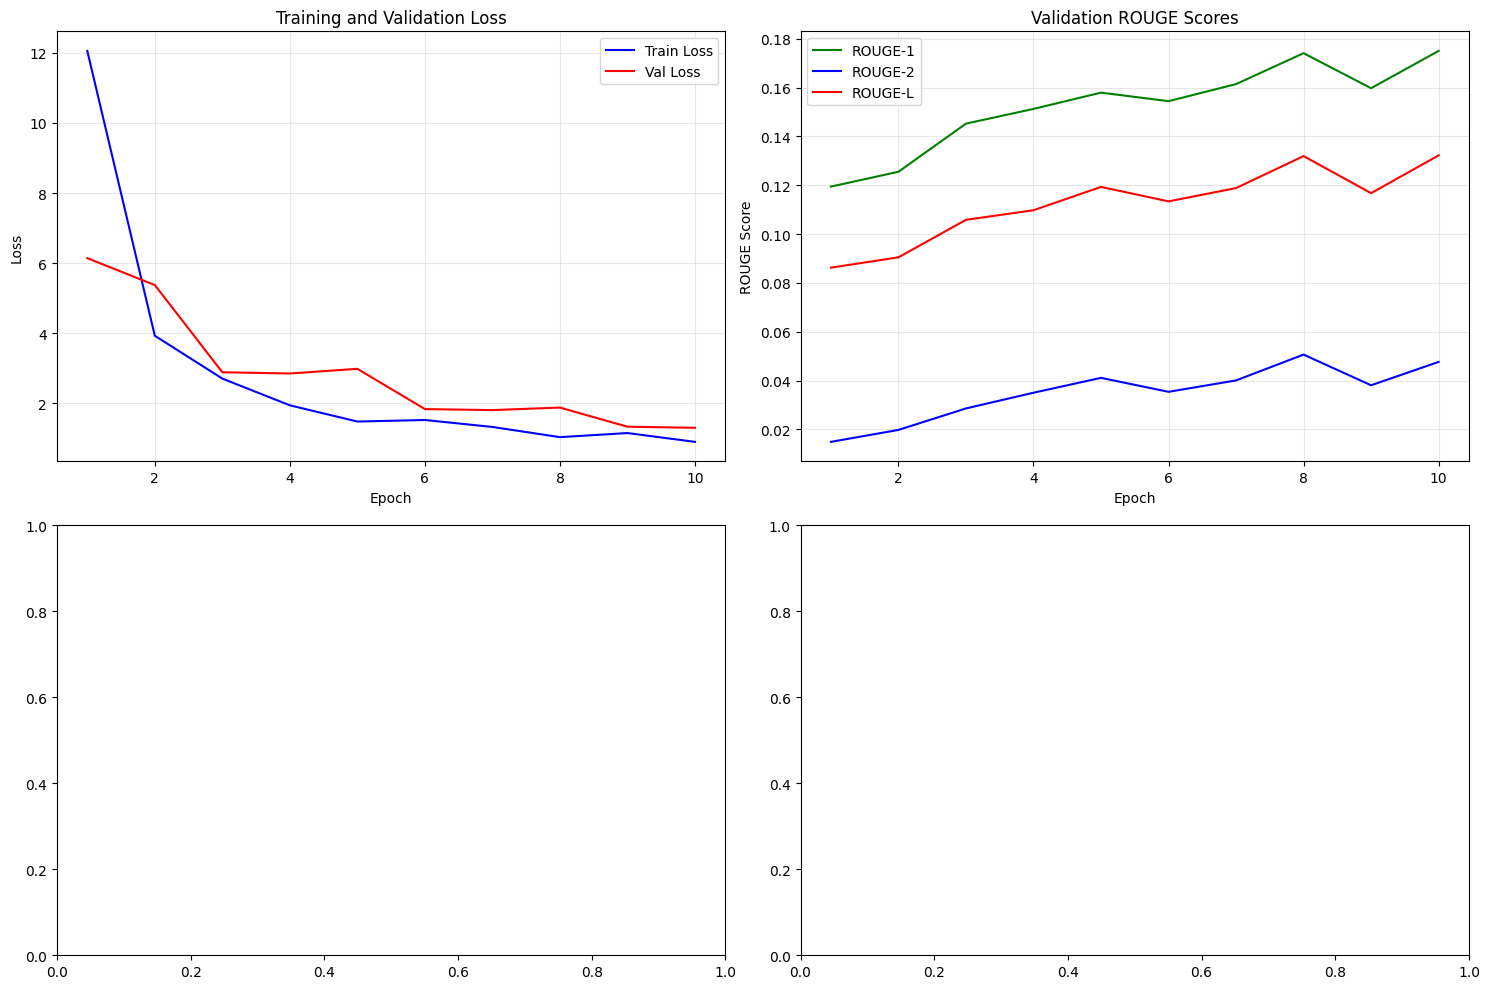

Plot saved as training_curves.png


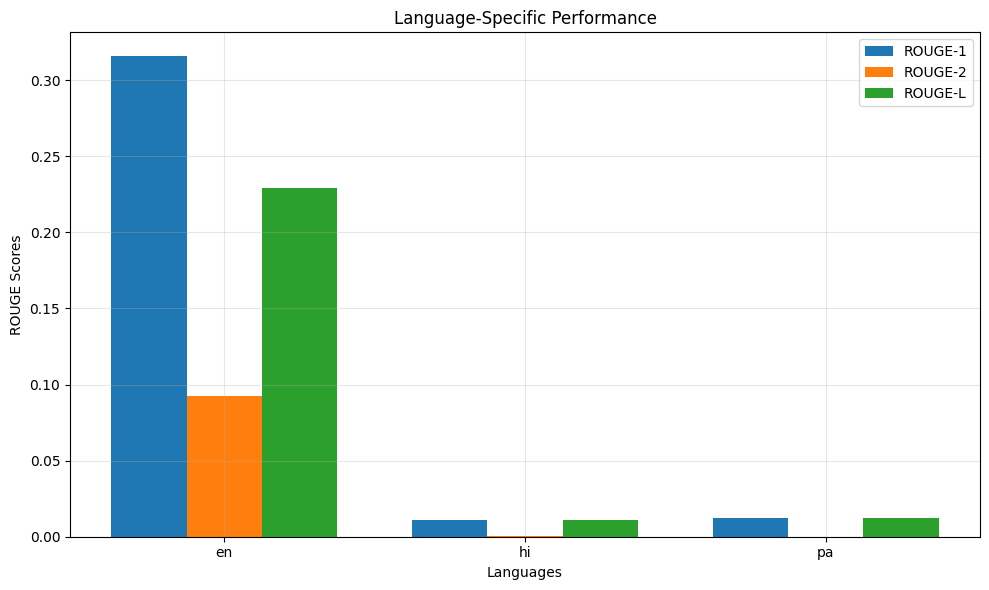


Expert Specialization Analysis

--- Layer 0: base_model.encoder.block.0.layer.1.DenseReluDense.moe_layer ---
Total expert calls: 2129246976

Expert Usage Distribution:
  Expert 0 (EN expert): 105726104 calls (  5.0%)
  Expert 1 (HI expert): 170046656 calls (  8.0%)
  Expert 2 (PU expert): 338087968 calls ( 15.9%)
  Expert 3 (shared): 508452800 calls ( 23.9%)
  Expert 4 (shared): 62287392 calls (  2.9%)
  Expert 5 (shared): 944646080 calls ( 44.4%)

Load Balance Metrics:
  Ideal usage per expert: 16.7%
  Max deviation: 27.7%
  ❌ POOR balance (deviation > 20%)

Capacity Overflow:
  Total overflow: 1562004983 tokens
  Overflow rate: 136.24%
  ❌ HIGH overflow (> 10%) - consider increasing capacity_factor

--- Layer 1: base_model.encoder.block.1.layer.1.DenseReluDense.moe_layer ---
Total expert calls: 2128975104

Expert Usage Distribution:
  Expert 0 (EN expert): 745529344 calls ( 35.0%)
  Expert 1 (HI expert): 41605564 calls (  2.0%)
  Expert 2 (PU expert): 338611456 calls ( 15.9%)
  Expe

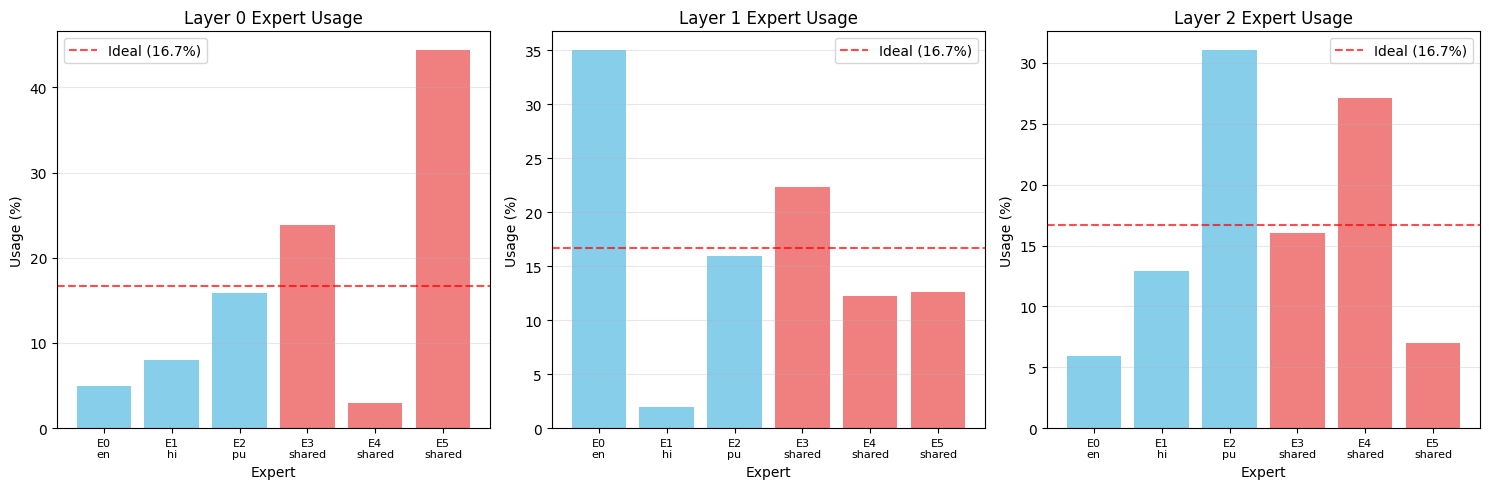


✓ All visualizations generated successfully



In [34]:
# ===== VISUALIZE TRAINING RESULTS =====
print("\n" + "="*70)
print("GENERATING VISUALIZATIONS")
print("="*70 + "\n")

# Plot training curves
plot_training_curves(training_history)

# Plot per-language performance
plot_language_performance(language_rouge)

# Analyze expert specialization
analyze_expert_specialization(model)

print("\n✓ All visualizations generated successfully\n")

In [35]:
# ===== SAVE FINAL MODEL AND RESULTS =====
print("\n" + "="*70)
print("SAVING FINAL MODEL AND RESULTS")
print("="*70 + "\n")

import json
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save model checkpoint
final_checkpoint_path = f"./checkpoints/final_model_{timestamp}"
os.makedirs(final_checkpoint_path, exist_ok=True)

torch.save({
    'model_state_dict': model.state_dict(),
    'config': config.__dict__,
    'training_history': training_history,
    'test_results': {
        'overall': overall_rouge,
        'per_language': language_rouge
    },
    'timestamp': timestamp
}, f"{final_checkpoint_path}/model_final.pt")

print(f"✓ Model saved to: {final_checkpoint_path}/model_final.pt")

# Save detailed results as JSON
final_results = {
    'timestamp': timestamp,
    'configuration': {
        'learning_rate': float(config.learning_rate),
        'batch_size': config.batch_size,
        'gradient_accumulation_steps': config.gradient_accumulation_steps,
        'effective_batch_size': config.batch_size * config.gradient_accumulation_steps,
        'num_epochs': config.num_epochs,
        'warmup_steps': config.warmup_steps,
        'weight_decay': float(config.weight_decay),
        'gradient_clip_val': float(config.gradient_clip_val),
        'aux_loss_weight_end': float(config.aux_loss_weight_end),
        'expert_dropout': float(config.expert_dropout),
        'num_experts': config.num_experts,
        'top_k': config.top_k,
    },
    'training': {
        'train_losses': [float(x) for x in training_history['train_losses']],
        'val_losses': [float(x) for x in training_history['val_losses']],
        'val_rouge_scores': training_history['val_rouge_scores'],
        'training_time_hours': training_history['training_time'] / 3600,
        'curriculum_phases': [p for p in training_history.get('phases', [])]
    },
    'test_results': {
        'overall': {
            'rouge1': float(overall_rouge['rouge1']),
            'rouge2': float(overall_rouge['rouge2']),
            'rougeL': float(overall_rouge['rougeL'])
        },
        'per_language': {
            lang: {
                'rouge1': float(scores['rouge1']),
                'rouge2': float(scores['rouge2']),
                'rougeL': float(scores['rougeL'])
            }
            for lang, scores in language_rouge.items()
        }
    }
}

results_path = f"final_results_{timestamp}.json"
with open(results_path, 'w') as f:
    json.dump(final_results, f, indent=2)

print(f"✓ Results saved to: {results_path}")

# Print final summary
print("\n" + "="*70)
print("FINAL TRAINING SUMMARY")
print("="*70)
print(f"\nConfiguration:")
print(f"  Model: {config.model_name}")
print(f"  Learning Rate: {config.learning_rate:.2e}")
print(f"  Epochs: {config.num_epochs}")
print(f"  Effective Batch Size: {config.batch_size * config.gradient_accumulation_steps}")

print(f"\nTraining Results:")
print(f"  Training Time: {training_history['training_time']/3600:.2f} hours")
print(f"  Final Train Loss: {training_history['train_losses'][-1]:.4f}")
print(f"  Final Val Loss: {training_history['val_losses'][-1]:.4f}")

print(f"\nTest Results:")
print(f"  Overall ROUGE-1: {overall_rouge['rouge1']:.4f}")
print(f"  Overall ROUGE-2: {overall_rouge['rouge2']:.4f}")
print(f"  Overall ROUGE-L: {overall_rouge['rougeL']:.4f}")

print(f"\nPer-Language ROUGE-L:")
for lang, scores in language_rouge.items():
    print(f"  {lang.upper()}: {scores['rougeL']:.4f}")

print("\n" + "="*70)
print("✓ TRAINING PIPELINE COMPLETED SUCCESSFULLY!")
print("="*70 + "\n")


SAVING FINAL MODEL AND RESULTS

✓ Model saved to: ./checkpoints/final_model_20251117_030731/model_final.pt
✓ Results saved to: final_results_20251117_030731.json

FINAL TRAINING SUMMARY

Configuration:
  Model: google/mt5-small
  Learning Rate: 3.00e-02
  Epochs: 10
  Effective Batch Size: 64

Training Results:
  Training Time: 4.85 hours
  Final Train Loss: 0.8987
  Final Val Loss: 1.2999

Test Results:
  Overall ROUGE-1: 0.1752
  Overall ROUGE-2: 0.0501
  Overall ROUGE-L: 0.1285

Per-Language ROUGE-L:
  EN: 0.2291
  HI: 0.0107
  PA: 0.0122

✓ TRAINING PIPELINE COMPLETED SUCCESSFULLY!

✓ Model saved to: ./checkpoints/final_model_20251117_030731/model_final.pt
✓ Results saved to: final_results_20251117_030731.json

FINAL TRAINING SUMMARY

Configuration:
  Model: google/mt5-small
  Learning Rate: 3.00e-02
  Epochs: 10
  Effective Batch Size: 64

Training Results:
  Training Time: 4.85 hours
  Final Train Loss: 0.8987
  Final Val Loss: 1.2999

Test Results:
  Overall ROUGE-1: 0.1752
  O